In [ ]:
import sys

!{sys.executable} -m pip install --upgrade pip
%pip install boto3
%pip install requests-auth-aws-sigv4
%pip install ndjson
%pip install pandas
%pip install matplotlib
%pip install fhirclient


In [2]:
%load_ext autoreload
%autoreload 2


from requests_auth_aws_sigv4 import  AWSSigV4
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from taskmetric import *
from participant import *
from healthrecords import *
from ppmg_functions import *
from constants import *

# 1. Downlaod Study Data

----

### Demo Server: SMART Sandbox

Fetch resources from the SMART sandbox server - R4

In [4]:
def get_resources_SMART(fn, path):
    query = 'https://r4.smarthealthit.org/' + path 
    request_data(fn, query) 


search_tag = '_tag=' + PPMG_TAG_DEBUG()

# Enrollment and registration
get_resources_SMART('Patient.ndjson',                   'Patient?'              + search_tag)
get_resources_SMART('Consent.ndjson',                   'Consent?'              + search_tag)
get_resources_SMART('ResearchSubject.ndjson',           'ResearchSubject?'      + search_tag)

# per-task measures
get_resources_SMART('task_metrics.ndjson','Observation?code=taskattemptv2')

# records, pghd
get_resources_SMART('Observation.ndjson',               'Observation?'          + search_tag)
get_resources_SMART('Medication.ndjson',                'Medication?'           + search_tag)
get_resources_SMART('MedicationStatement.ndjson',       'MedicationStatement?'  + search_tag)
get_resources_SMART('MedicationRequest.ndjson',         'MedicationRequest?'    + search_tag)
get_resources_SMART('Condition.ndjson',                 'Condition?'            + search_tag)
get_resources_SMART('QuestionnaireResponse.ndjson',     'QuestionnaireResponse?'+ search_tag)
get_resources_SMART('RiskAssessment.ndjson',            'RiskAssessment?'       + search_tag)
get_resources_SMART('DocumentReference.ndjson',         'DocumentReference?'    + search_tag)
get_resources_SMART('CommunicationRequest.ndjson',      'CommunicationRequest?' + search_tag)



Query: https://r4.smarthealthit.org/Patient?_tag=people-heart-study-debug
. 3	| output/Patient.ndjson

Query: https://r4.smarthealthit.org/Consent?_tag=people-heart-study-debug
. 3	| output/Consent.ndjson

Query: https://r4.smarthealthit.org/ResearchSubject?_tag=people-heart-study-debug
. 5	| output/ResearchSubject.ndjson

Query: https://r4.smarthealthit.org/Observation?code=taskattemptv2
. 15	| output/task_metrics.ndjson

Query: https://r4.smarthealthit.org/Observation?_tag=people-heart-study-debug
..... 230	| output/Observation.ndjson

Query: https://r4.smarthealthit.org/Medication?_tag=people-heart-study-debug
. 0	| output/Medication.ndjson

Query: https://r4.smarthealthit.org/MedicationStatement?_tag=people-heart-study-debug
. 13	| output/MedicationStatement.ndjson

Query: https://r4.smarthealthit.org/MedicationRequest?_tag=people-heart-study-debug
. 2	| output/MedicationRequest.ndjson

Query: https://r4.smarthealthit.org/Condition?_tag=people-heart-study-debug
. 0	| output/Condit

### AWS-DBMI FHIR Server: People Heart Study HealthLake

Fetch data from the AWS Setup at DBMI Landing zone

In [ ]:
def get_aws_dbmi_resources(fn, path):
    pass

# 2. Make Dataframes

------

Sort and normalize data -- convert to dataframe

In [7]:
all_records = all_study_data_records()
print(f'Number of records, pghd: {len(all_records)}')

# -----------------------------------------------------------
# Create Participants, and assign records, surveys, metrics

participants = [Participant(fhirpatient=pt) for pt in get_json_array('Patient.ndjson', patient.Patient)] 
all_task_metrics = [TaskAttempt(o) for o in get_json_array('task_metrics.ndjson', observation.Observation)]
all_survey_responses = get_json_array('QuestionnaireResponse.ndjson', questionnaireresponse.QuestionnaireResponse)

# assign records, survey_responses and task_metrics to the appropriate participant
for part in participants:

    part.assign_consent_status(
        consent_list=get_json_array('Consent.ndjson', consent.Consent),
        rs_list=get_json_array('ResearchSubject.ndjson', researchsubject.ResearchSubject))

    if len(all_records) > 0:
        part.assign_healthrecord(all_records)
        if len(all_survey_responses) > 0:
            demographics_list = list(filter(lambda qr: qr.identifier.value == 'demographic-survey' and qr.subject.reference == part.reference_uri, all_survey_responses))
            if demographics_list:
                part.assign_demographics(demographics_list[0])

    if all_task_metrics:
        part.assign_attempts(all_task_metrics)


df = None 
if len(participants) > 0: 
    pdict = [{'id': p.identifier, 
              'name': p.name,
              'enrollment_date': p.enrolledDate,
              'participation_status': p.status,
              'age': p.age,
              'gender': p.gender,
              'race': p.race,              
             } for p in participants]
    if len(pdict) > 0:
        df = pd.DataFrame(pdict).set_index('id').sort_values(by=['enrollment_date'])
    else:
        print('no participants found')
else:
    print('No participants found')
    
df


Number of records, pghd: 261


,name,enrollment_date,participation_status,age,gender,race
id,,,,,,
FE27A2FD-EC6A-4143-BDB7-9777F46334A9,Rahe Lsae,2023-05-10 03:00:09.441000-04:00,off-study,41,male,Hispanic or Latino
39550AE1-9C00-43A5-A58C-144171CD4A8A,Asaad M,2023-05-10 11:35:06.909000-04:00,off-study,41,male,Other
DE268333-CBA7-4997-8D5F-203326C592E8,John Doe,2023-05-10 12:00:09.032000-04:00,on-study,41,female,Asian


# 3. Overall participation status
--------------------------------

Number of participants enrolled and their status

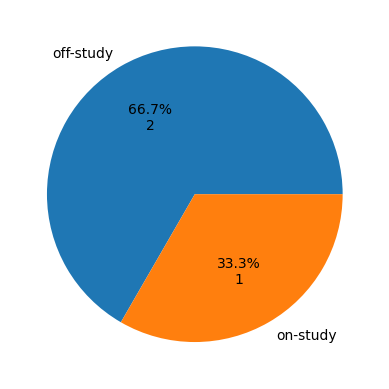

In [8]:
def fmt(x):
        return '{:.1f}%\n{:.0f}'.format(x, enrollment_status*x/100)
        
if df is not None:
    enrollment_status = df['participation_status'].value_counts().values.sum()
    plt.pie(df['participation_status'].value_counts().values, labels=df['participation_status'].value_counts().index, autopct=fmt)
else:
    print('dataframe-\'df\' not intialized')

# 4. Longitudional Participant
------------------------------

Select a participant by their id and analyze

In [9]:
# Select Participant
participant = participants[0]

# a fuunction to get participant obj using their synthetic identifier
# due!

# participant records df
records_df = None 

if participant.records is None:
    print(f'No records found for this participant: {participant.identifier}')
else:

    # get records from participant. This includes the self-attested answers
    p_records = participant.records
    records_df = pd.DataFrame([r.as_json() for r in p_records]).sort_values(['code'])
    records_df


records_df

,identifier,name,code,date,value,subject_id,resource_type
2,1551040,LDL chol calc (nih),13457-7,2021-03-22,128,Patient/1550792,Observation
8,1551046,LDL chol calc (nih),13457-7,2021-11-22,157,Patient/1550792,Observation
143,1551239,Low Density Lipoprotein Cholesterol,18262-6,2011-07-26,77,Patient/1550792,Observation
138,1551234,Low Density Lipoprotein Cholesterol,18262-6,2014-07-24,63,Patient/1550792,Observation
137,1551233,Low Density Lipoprotein Cholesterol,18262-6,2017-04-02,71,Patient/1550792,Observation
...,...,...,...,...,...,...,...
221,1551298,Study communication,RESCH,2023-05-10,None,Patient/1550792,CommunicationRequest
219,1551289,None,chronicConditions,2023-05-10,ss,Patient/1550792,QuestionnaireResponse
215,1550982,None,demographic-survey,2023-05-10,None,Patient/1550792,QuestionnaireResponse
216,1551286,None,familyHistoryOfPrematureCVD,2023-05-10,True,Patient/1550792,QuestionnaireResponse


### 4.1 Plot Cholesterols & Lipids

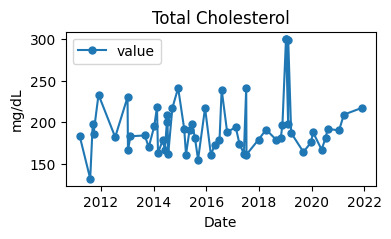

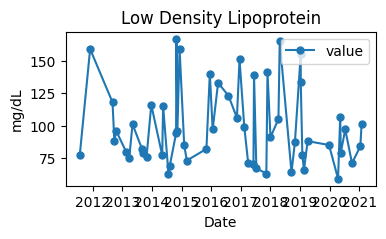

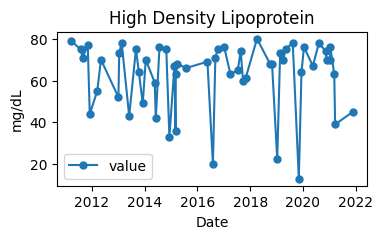

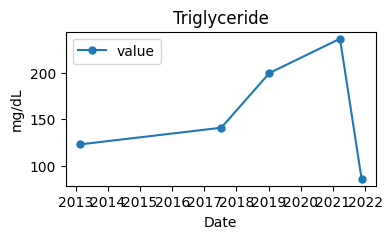

In [10]:
t_chol = records_df[records_df['code'] == '2093-3']
ldl = records_df[records_df['code'] == '18262-6']
hdl = records_df[records_df['code'] == '2085-9']
tg = records_df[records_df['code'] == '2571-8']

if t_chol.empty and ldl.empty and hdl.empty and tg.empty: 
    print('No records found to plot Cholesterol and Lipids')
    
if not t_chol.empty:
    t_chol.plot(x='date', y='value', xlabel='Date', ylabel='mg/dL', title='Total Cholesterol', style="o-", ms=5, figsize = (4, 2))
if not ldl.empty:
    ldl.plot(x='date', y='value', xlabel='Date', ylabel='mg/dL', title='Low Density Lipoprotein', style="o-", ms=5, figsize = (4, 2))
if not hdl.empty:
    hdl.plot(x='date', y='value', xlabel='Date', ylabel='mg/dL', title='High Density Lipoprotein', style="o-", ms=5, figsize = (4, 2))
if not tg.empty:    
    tg.plot(x='date', y='value', xlabel='Date', ylabel='mg/dL', title='Triglyceride', style="o-", ms=5, figsize = (4, 2))



### per-TaskMetrics

Tasks attempted and their metrics.

In [11]:

df_metrics = pd.DataFrame([me.as_dict() for me in participant.attempts]).sort_values(by=['task_begin', 'task_end'], ascending=False)
df_metrics

,task_id,task_elapsed_time,task_begin,task_end,task_result,subject
6,risk_recommendation,14.02117,2023-05-10 07:44:53.134000+00:00,2023-05-10 07:45:07.155170+00:00,completedWithSuccess,Patient/1550792
5,risk_enhancers,1.43390,2023-05-10 07:44:36.704200+00:00,2023-05-10 07:44:38.138100+00:00,completedWithSuccess,Patient/1550792
4,risk_enhancers,2.75030,2023-05-10 07:44:35.387600+00:00,2023-05-10 07:44:38.137900+00:00,completedWithSuccess,Patient/1550792
3,risk_enhancers,8.53340,2023-05-10 07:44:29.604500+00:00,2023-05-10 07:44:38.137900+00:00,completedWithSuccess,Patient/1550792
2,risk_enhancers,10.54830,2023-05-10 07:44:27.589400+00:00,2023-05-10 07:44:38.137700+00:00,completedWithSuccess,Patient/1550792
1,clinical_records,7.63760,2023-05-10 07:42:44.449800+00:00,2023-05-10 07:42:52.087400+00:00,completedWithSuccess,Patient/1550792
0,demographics_survey,5.09430,2023-05-10 07:33:53.129000+00:00,2023-05-10 07:33:58.223300+00:00,completedWithSuccess,Patient/1550792
